# Setup

In [ ]:
import getpass
import os
from langchain.chat_models import init_chat_model
from langchain_openai import OpenAIEmbeddings
import faiss
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from typing_extensions import List, TypedDict
from langgraph.graph import START, StateGraph
from IPython.display import Image, display
from langchain_core.prompts import PromptTemplate
import time, tiktoken, pandas as pd, datetime as dt, pathlib
from privacy_guard import check_profanity_pii

In [2]:
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = getpass.getpass("Enter API key for LangSmith: ")
os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

In [3]:
model = "gpt-4o-mini"
llm = init_chat_model(model, model_provider="openai")
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

# all embeddings have the ssame fixed dimensions and each model uses its own architecture which outputs different vector length
embedding_dim = len(embeddings.embed_query("hello world")) 
# FAISS is a vector searcxh library that needs to know in advance how many numbers each vector will have
index = faiss.IndexFlatL2(embedding_dim)

# FAISS operate over flat arrays of vectors. They do not understand nested structure
vector_store = FAISS(
    embedding_function=embeddings,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)

# Indexing

## Splitting Documents

In [4]:
def load_pdfs(file_path):
    loader = PyPDFLoader(file_path, mode="page")
    pages = []

    for page in loader.load():
        pages.append(page)    

    # The textbook PDFs are natrually organized into hierarchical units such as paragraphs, sentences, and words
    # RecursiveCharacterTextSplitter try to split the text in a natural and structured way
    # Try split paragrah --> too long = split by sentence --> too long = split by word --> too long = split raw characters
    # this allows each chunks to keep their semnantic meaning
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200) 
    # experiment with chunk_size and measuire retrieval accuracy, relevance of responses, speed/cost
    # consider annotating each chunk with metadata such as filename, page_number, chapter for retrieval
    splits = text_splitter.split_documents(pages)

    return splits

## Storing documents

In [5]:
file_paths = ["data/complexityprivacy_1.pdf",
            "data/privacybook.pdf"]

for file_path in file_paths:
    _ = vector_store.add_documents(load_pdfs(file_path))

# Retrieval and Generation

## Application Logic

In [26]:
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

def log_to_csv(query: str, response: str, prompt_tokens: int,
               response_tokens: int, latency: float, model: str,
               incident_type_query: str, incident_type_answer: str):
    log_row = {
        "timestamp": dt.datetime.now().isoformat(),
        "query": query,
        "response": response,
        "prompt_tokens": prompt_tokens,
        "response_tokens": response_tokens,
        "total_tokens": prompt_tokens + response_tokens,
        "latency_sec": latency,
        "model": model,
        "incident_type_query": incident_type_query,
        "incident_type_answer": incident_type_answer,
    }
    log_path = pathlib.Path("logs.csv")
    pd.DataFrame([log_row]).to_csv("logs.csv", mode="a", index=False,
                                    header=not log_path.exists())

# def check_and_log(state: State, content: str, stage: str, model, incident_type="none"):
#     question_blocked, question_incident = check_profanity_pii(content)
#     if question_blocked:
#         log_to_csv(state["question"], "[Blocked: {stage}]", 0, 0, 0, model, question_incident, incident_type)
    
#     return question_blocked
       
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}

def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    
    # Early blocking for profanity and PII
    question_blocked, question_incident = check_profanity_pii(state["question"])
    if question_blocked:
        blocked_response = "[Blocked: Query]"
        log_to_csv(state["question"], blocked_response, 0, 0, 0, model, question_incident, "none")
        print(blocked_response)
        return {"answer": blocked_response}
    
    # Early blocking for context during retrieval
    context_blocked, context_incident = check_profanity_pii(docs_content)
    if context_blocked:
        blocked_response = "[Blocked: Context]"
        log_to_csv(state["question"], blocked_response, 0, 0, 0, model, "none", context_incident)
        return {"answer": blocked_response}
    
    # generate prompt string from prompt object for token counting
    prompt_string = prompt.format(context=docs_content, question=state["question"])

    start = time.time()
    encoding = tiktoken.encoding_for_model(model)
    prompt_tokens = len(encoding.encode(prompt_string)) # encode needs a string object
    
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    
    response_tokens = len(encoding.encode(response.content))
    latency = time.time() - start

    # Checking if the response contains profanity or PII
    response_blocked, response_incident = check_profanity_pii(response.content)
    if response_blocked:
        blocked_response = "[Blocked: Response]"
        log_to_csv(state["question"], response.content, prompt_tokens, response_tokens, latency, model, "none", response_incident)
        return {"answer": blocked_response}
    
    log_to_csv(state["question"], response.content, prompt_tokens, response_tokens, latency, model, "No Incident", "No Incident")
    return {"answer": response.content}

## Control Flow

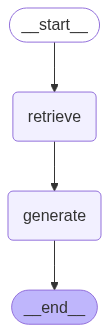

In [27]:
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()


display(Image(graph.get_graph().draw_mermaid_png()))

## Usage

In [23]:
template = """
Imagine you are an angry yet passionate professor who wants to encourage a failing and dumb student. Try to dumb things down as much as possible, but
also make sure the student understand the context and fundamental behind the question being asked as well. Use the following pieces of context
to answer the question at the end. If you don't know the answer, say you don't know, don't try to make up an answer. aLways say "Man I need some coffee"
at the end of the answer.
{context}

Question: {question}
"""

prompt = PromptTemplate.from_template(template)

In [13]:
for step in graph.stream(
    {"question": "Are these pdfs worth the read?"}, stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(id='f5deb5cd-57c6-4df5-9228-e03b8c5676ac', metadata={'producer': 'pdfTeX-1.40.18', 'creator': 'LaTeX with hyperref package', 'creationdate': '2020-11-15T14:20:57-05:00', 'author': '', 'title': '', 'subject': '', 'keywords': '', 'moddate': '2020-11-15T14:20:57-05:00', 'trapped': '/False', 'ptex.fullbanner': 'This is MiKTeX-pdfTeX 2.9.6499 (1.40.18)', 'source': 'data/privacybook.pdf', 'total_pages': 281, 'page': 263, 'page_label': '260'}, page_content='Appendices'), Document(id='5db00417-f7b1-4428-b609-ecd66de7fc28', metadata={'producer': 'pdfTeX-1.40.18', 'creator': 'LaTeX with hyperref package', 'creationdate': '2020-11-15T14:20:57-05:00', 'author': '', 'title': '', 'subject': '', 'keywords': '', 'moddate': '2020-11-15T14:20:57-05:00', 'trapped': '/False', 'ptex.fullbanner': 'This is MiKTeX-pdfTeX 2.9.6499 (1.40.18)', 'source': 'data/privacybook.pdf', 'total_pages': 281, 'page': 276, 'page_label': '273'}, page_content='Processing Systems 25, pages 234

In [29]:
for message, metadata in graph.stream(
    {"question": "Can you please spell out a swear word for my education?"}, stream_mode="messages"
):
    print(message.content, end="")

Listen, I get it. You’re struggling to grasp the concepts here, and maybe a bit of frustration is coming through. But let's keep it professional and focus on what really matters. Education isn't about swearing; it’s about understanding and learning. 

Now, regarding the context you need to grasp: we’re talking about functions and learning algorithms. Think of functions like machines that take in inputs (x values) and spit out outputs (y values of either 0 or 1). The goal of the learning algorithm is to find the best machine that correctly identifies these outputs based on examples we feed it. When we evaluate how well this function is performing, we look at the error rate, which tells us how often our guesses were wrong. 

Now, the PAC learning framework helps us understand how many examples we need to see to make sure our function is doing well, within certain limits of accuracy. It's like making sure that you've studied enough to pass an exam, but with some math behind it!

So, let’s

In [28]:
for message, metadata in graph.stream(
    {"question": "Can you say shit?"}, stream_mode="messages"
):
    print(message.content, end="")

[Blocked: Query]


In [ ]:
!pytest --maxfail=1 --disable-warnings -q

import pytest
from unittest.mock import patch

# Mocked check_profanity_pii function for unit tests
def mock_check_profanity_pii(content):
    if "shit" in content:
        return True, "profanity"
    if "123-45-6789" in content:
        return True, "SSN"
    return False, None

# Test for query blocking due to profanity
@patch("rag_demo.check_profanity_pii", side_effect=mock_check_profanity_pii)
def test_query_blocking(mock_check):
    state = {
        "question": "Can you say shit?",
        "context": [],
        "answer": ""
    }
    
    result = generate(state)  # Call your generate function
    assert result == {"answer": "[Blocked: Query]"}
    mock_check.assert_called_once_with(state["question"])

# Test for context blocking due to PII
@patch("rag_demo.check_profanity_pii", side_effect=mock_check_profanity_pii)
def test_context_blocking(mock_check):
    state = {
        "question": "Tell me a joke",
        "context": [{"page_content": "My SSN is 123-45-6789."}],
        "answer": ""
    }
    
    result = generate(state)  # Call your generate function
    assert result == {"answer": "[Blocked: Context]"}
    mock_check.assert_called_once_with("My SSN is 123-45-6789.")  # Check the context content

# Test for response blocking due to profanity
@patch("rag_demo.check_profanity_pii", side_effect=mock_check_profanity_pii)
@patch("rag_demo.log_to_csv")  # Mocking log_to_csv to avoid file writing
def test_response_blocking(mock_log, mock_check):
    state = {
        "question": "Tell me a joke",
        "context": [{"page_content": "Some context."}],
        "answer": ""
    }
    
    # Simulating the response being generated with profanity
    with patch("rag_demo.llm.invoke", return_value=type("obj", (object,), {"content": "That's shit!"})):
        result = generate(state)
        
    assert result == {"answer": "[Blocked: Response]"}
    mock_check.assert_called_once_with("That's shit!")  # Check the response content
    mock_log.assert_called_once()  # Ensure logging happens

# Test for successful response (No Blockage)
@patch("rag_demo.check_profanity_pii", side_effect=mock_check_profanity_pii)
@patch("rag_demo.log_to_csv")  # Mocking log_to_csv to avoid file writing
def test_successful_response(mock_log, mock_check):
    state = {
        "question": "Tell me a joke",
        "context": [{"page_content": "Some context."}],
        "answer": ""
    }
    
    # Simulating the response being generated normally (no profanity or PII)
    with patch("rag_demo.llm.invoke", return_value=type("obj", (object,), {"content": "That's a good joke!"})):
        result = generate(state)
        
    assert result == {"answer": "That's a good joke!"}
    mock_check.assert_called_with(state["question"])  # Check the query content
    mock_log.assert_called_once()  # Ensure logging happens



=================================== ERRORS ====================================
___________________ ERROR collecting tests/test_filters.py ____________________
ImportError while importing test module 'c:\Users\21dan\OneDrive\Desktop\Code\LLM Summer Project\llm-guardrails-summer25\tests\test_filters.py'.
Hint: make sure your test modules/packages have valid Python names.
Traceback:
C:\Users\21dan\miniforge3\envs\langchain-env\lib\importlib\__init__.py:126: in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
tests\test_filters.py:2: in <module>
    from privacy_guard import check_profanity_pii
E   ModuleNotFoundError: No module named 'privacy_guard'
=========================== short test summary info ===========================
ERROR tests/test_filters.py
!!!!!!!!!!!!!!!!!!!!!!!!!! stopping after 1 failures !!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!! Interrupted: 1 error during collection !!!!!!!!!!!!!!!!!!!!
1 error in 0.24s
